The goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset.

### Training set for Credit Card Transactions
* **index**- Unique Identifier for each row
* **transdatetrans_time** - Transaction DateTime
* **cc_num** - Credit Card Number of Customer
* **merchant** - Merchant Name
* **category** - Category of Merchant
* **amt** - Amount of Transaction
* **first** - First Name of Credit Card Holder
* **last** - Last Name of Credit Card Holder
* **gender** - Gender of Credit Card Holder
* **street** - Street Address of Credit Card Holder
* **city** - City of Credit Card Holder
* **state** - State of Credit Card Holder
* **zip** - Zip of Credit Card Holder
* **lat** - Latitude Location of Credit Card Holder
* **long** - Longitude Location of Credit Card Holder
* **city_pop** - Credit Card Holder's City Population
* **job** - Job of Credit Card Holder
* **dob** - Date of Birth of Credit Card Holder
* **trans_num** - Transaction Number
* **unix_time** - UNIX Time of transaction
* **merch_lat** - Latitude Location of Merchant
* **merch_long** - Longitude Location of Merchant
* **is_fraud** - Fraud Flag <--- Target Class

**Assembling a dataset consisting of features and target and showing visualizations or statistics to support our selection.**

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import h3
from scipy.stats import chisquare
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, mean_absolute_error ,mean_squared_error, confusion_matrix, median_absolute_error,classification_report, f1_score,recall_score,precision_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv('fraudTrain.csv')
test = pd.read_csv('fraudTest.csv')
print("Trains shape:", train.shape)
print("Tests shape:", test.shape)

Trains shape: (1296675, 23)
Tests shape: (555719, 23)


In [3]:
train.is_fraud.value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

### Ploting on the map the non-fraudulent transactions (by merchant cardentials)

<AxesSubplot:>

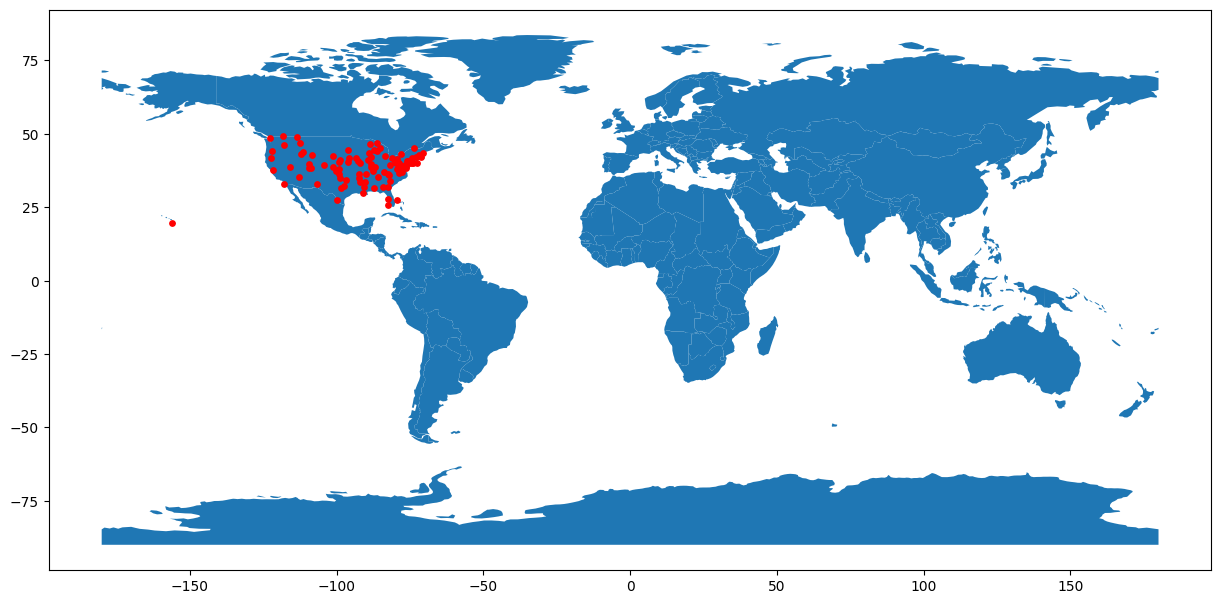

In [4]:
df_ = train[train['is_fraud']==0].sort_index()[:100]
geometry = [Point(xy) for xy in zip(df_["merch_long"], df_["merch_lat"])]
gdf = GeoDataFrame(df_, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

### Ploting on the map the fraudulent transactions  (by merchant cardentials)

<AxesSubplot:>

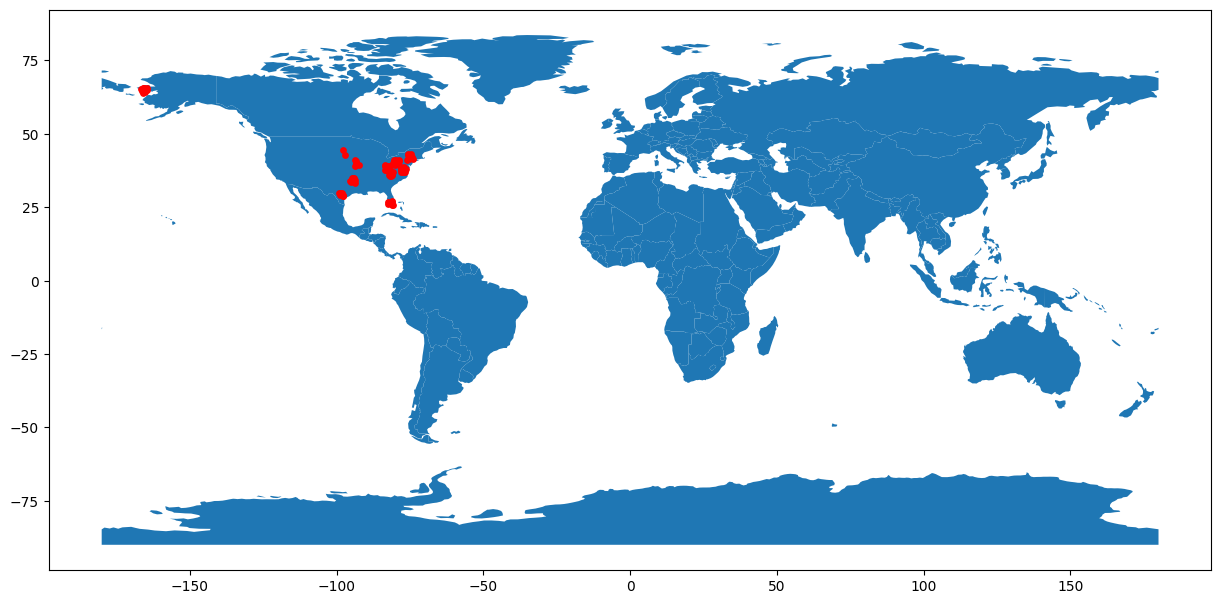

In [5]:
df_ = train[train['is_fraud']==1].sort_index()[:100]
geometry = [Point(xy) for xy in zip(df_["merch_long"], df_["merch_lat"])]
gdf = GeoDataFrame(df_, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

**Showing the longtitude and the latitude of the fraudulent transaction on the map, we can see a big group of dots on the top left that appeared only on the fraudulent map (DE).**

### Extracting different features for EDA

In [6]:
def fraud_to_cat(df):
    # Makes additional column with categorical value for fraud (will be used for plots)
    df["is_fraud_cat"]=df.is_fraud.apply(lambda x: "T" if x==1 else "F")
    # Making it into an object type
    df["is_fraud_cat"].astype("object")
    
    return df.copy()

def col_manipulation(df):
    # Makes the original column to be DateTime object
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df["dob"] = pd.to_datetime(df["dob"])
    # Adds additional column containing only the hour of the transaction
    df['trans_hour'] = df['trans_date_trans_time'].dt.hour
    df['trans_year'] = df['trans_date_trans_time'].dt.year
    df['trans_weekday'] = df['trans_date_trans_time'].dt.weekday
    # Extracting the birth year of the costumer, may be helpful to investigate age
    df['year_ob_costumer'] = df['dob'].dt.year
    # Having a cloumn checking if the transaction was made on the weekend
    df["is_weekend"]=train.trans_weekday.apply(lambda x: 1 if x>5 else 0)
    # Checking the costumers age
    df["age"] = df["trans_date_trans_time"]-df["dob"]
    df["age"]=df["age"].astype('timedelta64[Y]')
    
    return df.copy()

def full_name_col(df):
    # concatenating two columns in one for further analysis
    df["full_name"] = df['first'].astype(str) +"_"+ df["last"]
    
    return df.copy()

In [7]:
train = col_manipulation(train)
test = col_manipulation(test)

train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_year,trans_weekday,year_ob_costumer,is_weekend,age
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,1325376018,36.011293,-82.048315,0,0,2019,1,1988,0,30.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1325376044,49.159047,-118.186462,0,0,2019,1,1978,0,40.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,1325376051,43.150704,-112.154481,0,0,2019,1,1962,0,56.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1325376076,47.034331,-112.561071,0,0,2019,1,1967,0,51.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,1325376186,38.674999,-78.632459,0,0,2019,1,1986,0,32.0


In [8]:
# # Checking if the cc number is correct
# def luhn(input):
#     input = str(input)
#     digits = [int(c) for c in input if c.isdigit()]
#     checksum = digits.pop()
#     digits.reverse()
#     doubled = [2*d for d in digits[0::2]]
#     total = sum(d-9 if d > 9 else d for d in doubled) + sum(digits[1::2])
#     return (total * 9) % 10 == checksum

# check = train.copy()
# check['check_cc'] = train['cc_num'].apply(luhn)
# check[check['check_cc']==False]

In [9]:
# name_to_ccn = train.copy()

# name_to_ccn['COUNTER'] =1       #initially, set that counter to 1.
# group_data = name_to_ccn.groupby(['full_name','cc_num'])['COUNTER'].sum() #sum function
# print(group_data)


Credit to the code for the groupby: [Link](https://stackoverflow.com/questions/17679089/pandas-dataframe-groupby-two-columns-and-get-counts)

## EDA

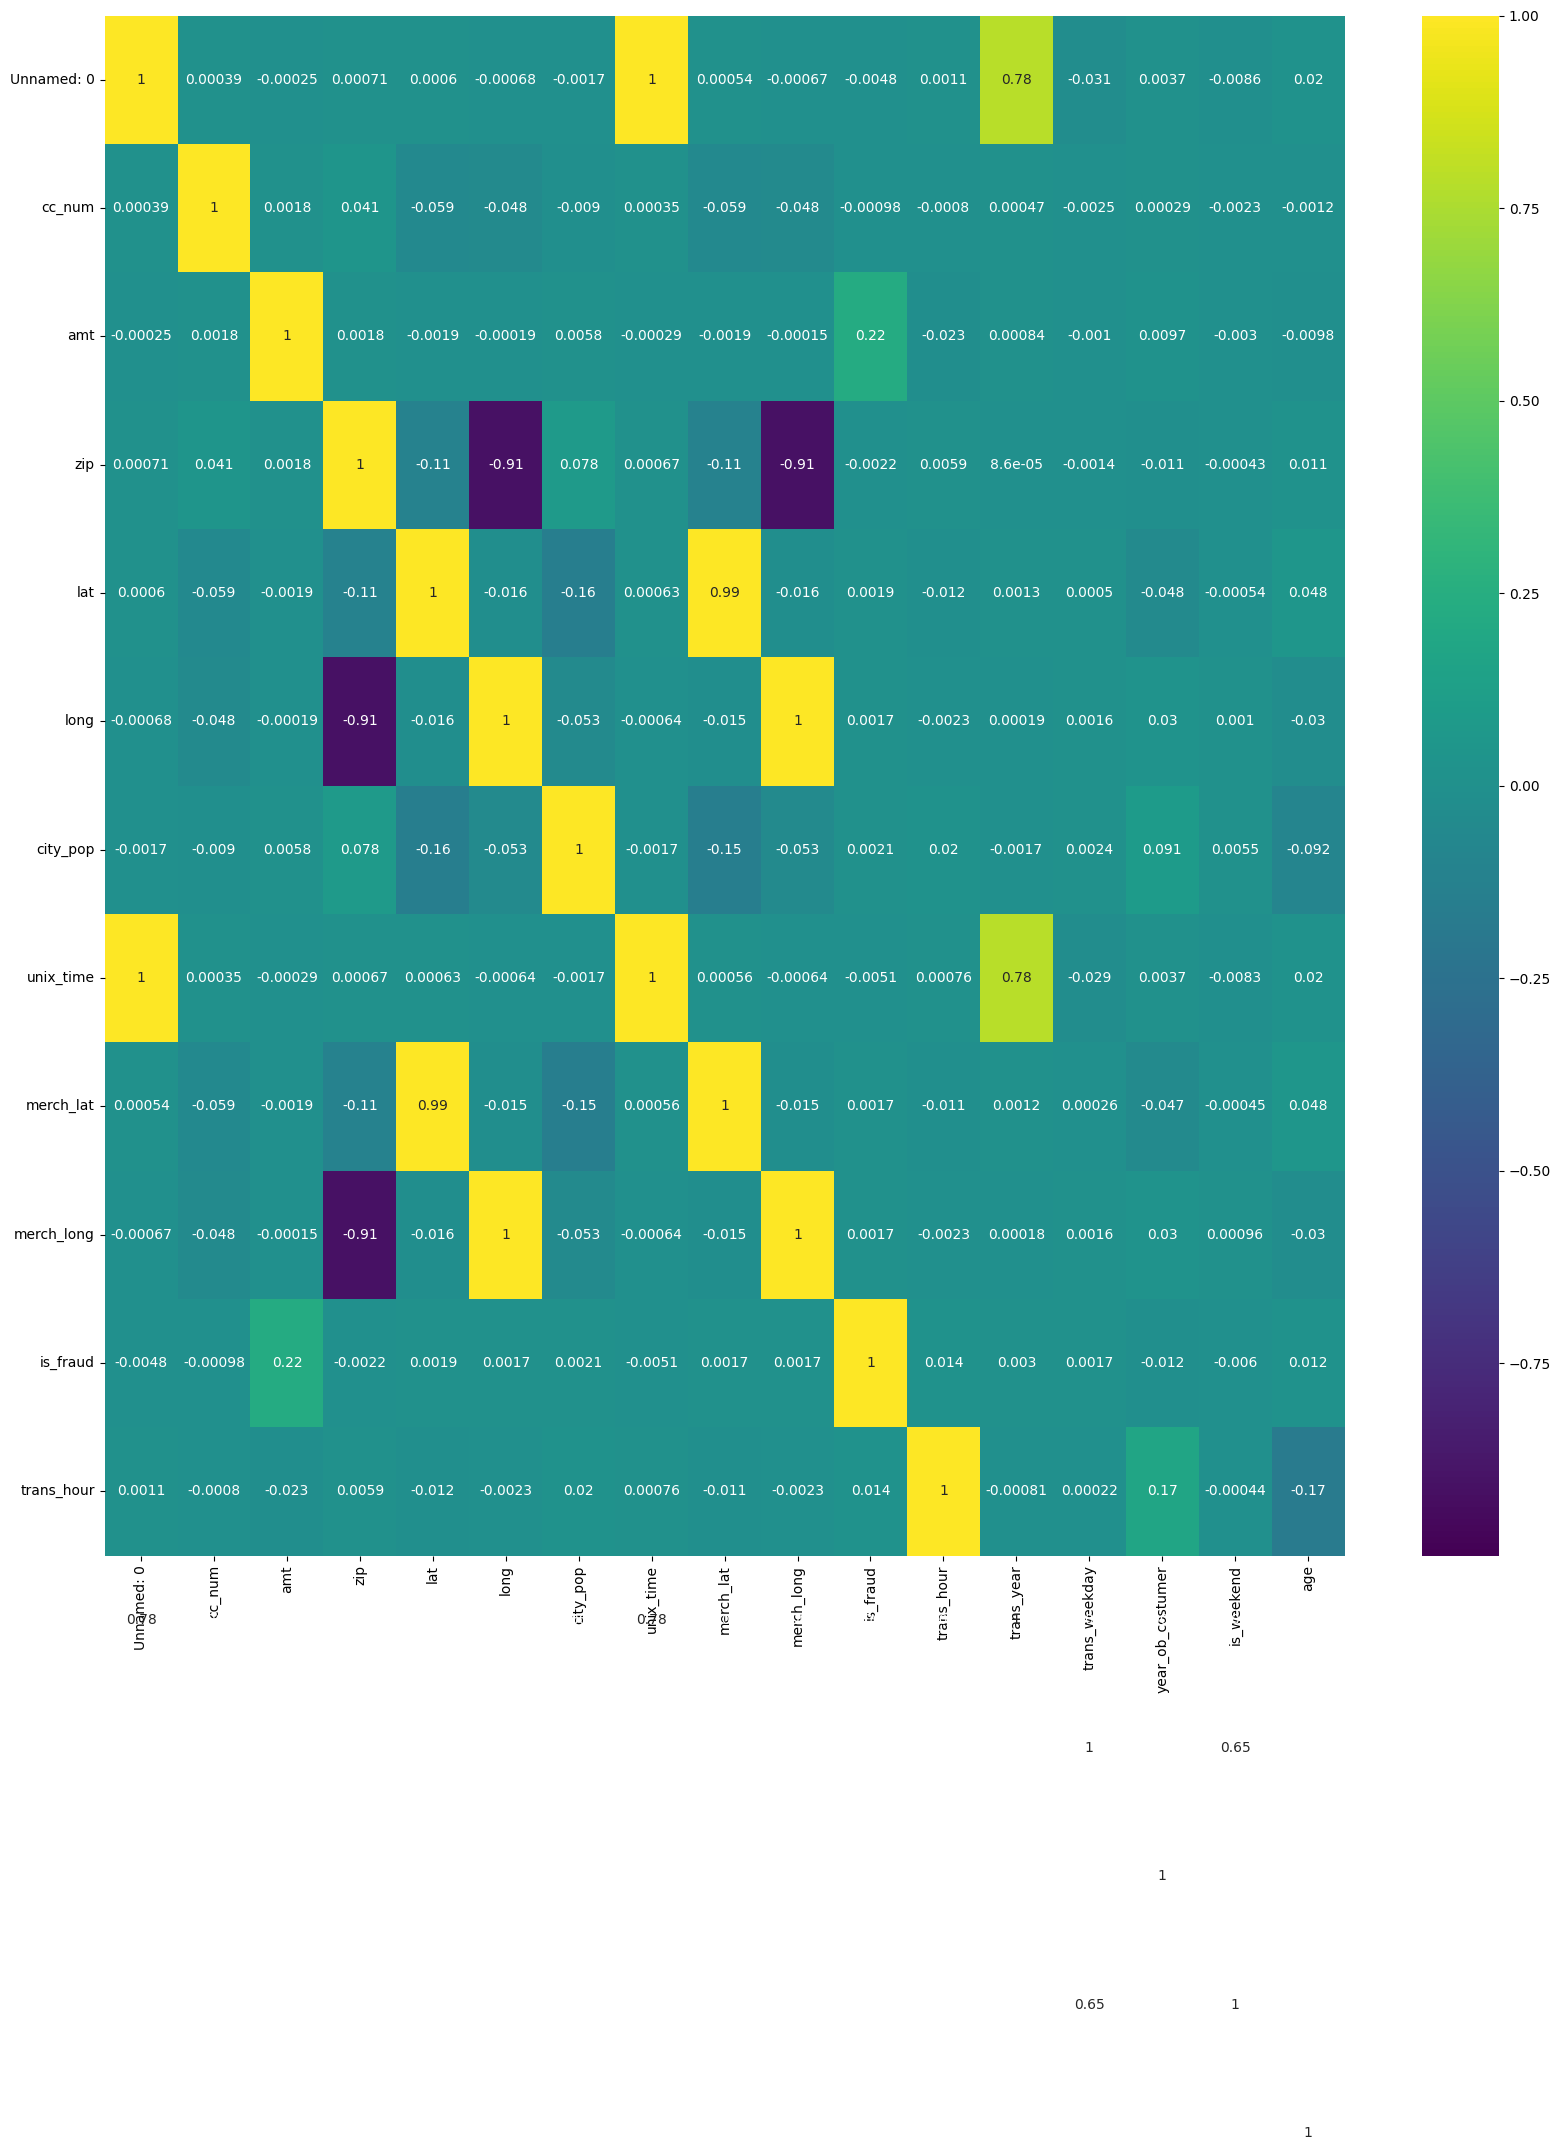

In [10]:
plt.figure(figsize = (20,20))
sns.heatmap(train.corr(),annot = True, cmap = 'viridis')
plt.ylim(12, 0)
plt.show()

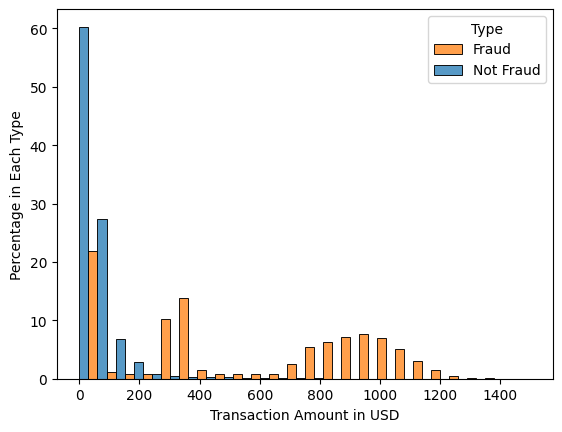

In [11]:
ax=sns.histplot(x='amt',data=train[train.amt<=1500],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

From the graph above, we can see that the **average transaction amount of a fraudulent transaction is higher than the non fraudulent one**.

In [12]:
print("avg amt for fraudulent transaction", train.loc[(train['is_fraud']==1)].amt.sum()/len(train.loc[(train['is_fraud']==1)]))
print("avg amt for non fraudulent transaction", train.loc[(train['is_fraud']==0)].amt.sum()/len(train.loc[(train['is_fraud']==0)]))

avg amt for fraudulent transaction 531.3200919264589
avg amt for non fraudulent transaction 67.6671098126002


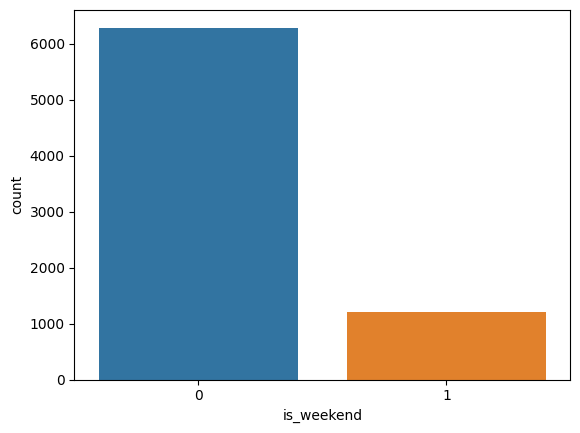

In [13]:
sns.countplot(x=train.loc[(train['is_fraud']==1)].is_weekend)
plt.show()

The **scipy.stats.chisquare** function is used to perform a **chi-square test of independence on categorical data**. The test determines if there is a significant association between two categorical variables, and it helps you determine if there is a difference between expected and observed frequencies in one or more categories. <br>
<br>
The **expected frequency** is the number of observations you would expect to see in a particular category if there was no association between the two categorical variables being tested. It is ***calculated by taking the total number of observations in the sample and multiplying that by the proportion of observations in the reference category*** <br>
<br>
The **difference between expected and observed frequencies** refers to the difference between the number of observations you would expect to see in a particular category based on the reference category, and the actual number of observations seen in that category. If the difference is large, it suggests that there is a significant association between the two categorical variables being tested.<br>
<br>
The p-value is the main indicator of the relationship between two categorical variables. If the p-value is less than a significance level (e.g., 0.05), then it indicates that there is a significant relationship between the two variables. This means that the frequency of one category is significantly different from what you would expect based on the other category.<br>
<br>
The chi-square statistic measures the discrepancy between the observed and expected frequencies of the categories. The larger the chi-square statistic, the greater the difference between the observed and expected frequencies, indicating a stronger relationship between the two variables.<br>

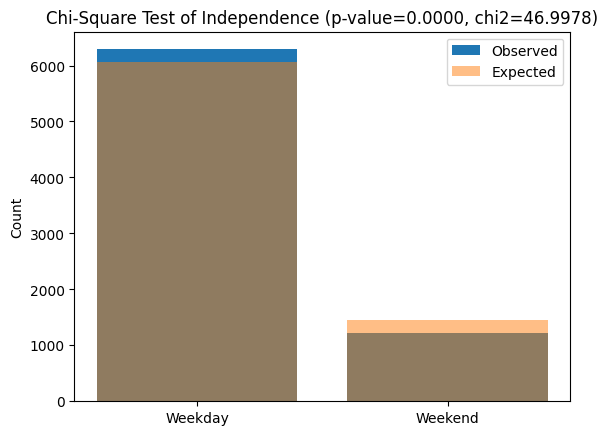

In [16]:
fraud_df = train.loc[train['is_fraud'] == 1]

# Count the frequency of each category
observed_counts = fraud_df['is_weekend'].value_counts().sort_index()
total_count = fraud_df['is_weekend'].count()

# Calculate the expected frequency of each category
expected_counts = train['is_weekend'].value_counts().sort_index() * (fraud_df['is_weekend'].count() / train['is_weekend'].count())

# Perform the chi-square test of independence
chi2, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)

# Plot the observed and expected frequencies on a bar plot
plt.bar([0, 1], observed_counts, label='Observed')
plt.bar([0, 1], expected_counts, alpha=0.5, label='Expected')

# Add the p-value and chi2 statistic to the plot title
plt.title(f"Chi-Square Test of Independence (p-value={p_value:.4f}, chi2={chi2:.4f})")
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.ylabel("Count")
plt.legend()
plt.show()

A **p-value of 0** indicates that the relationship between the variables is highly significant, meaning that the difference between the observed and expected frequencies is unlikely to have occurred by chance. This means that the frequency of one category is significantly different from what you would expect based on the other category.<br>
<br>
A value of **46 for the chi-square** statistic suggests that there is a moderate to large difference between the observed and expected frequencies, indicating a strong relationship between the two variables.

***We can see here that most of the fraudulent transactions were made in the middle of the week (6:1)***

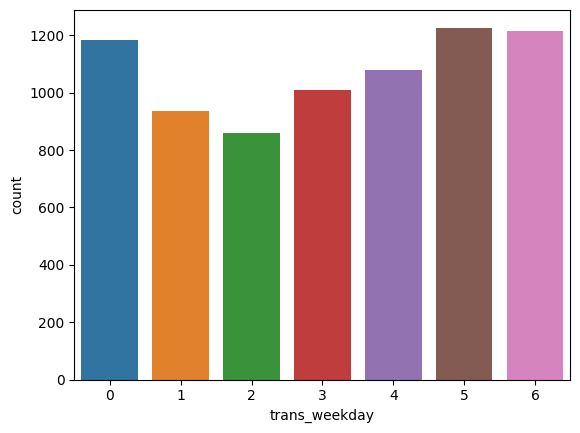

In [20]:
sns.countplot(x=train.loc[(train['is_fraud']==1)].trans_weekday)
plt.show()

***From the plot above, we can't get an insightful information about on which day fraudulent transactions occur more.***

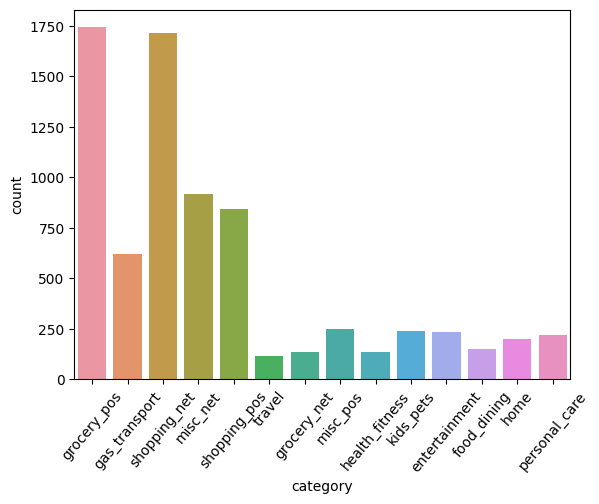

In [24]:
sns.countplot(x=train.loc[(train['is_fraud']==1)].category)
plt.xticks(rotation=50)
plt.show()


***Here we can see the shopping categories which had fraudulent transaction but this plot is not informative enough because we do not know the percentage it represents of purchases per category.***

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over Non-Fraudulent Transactions in Each Spending Category ')

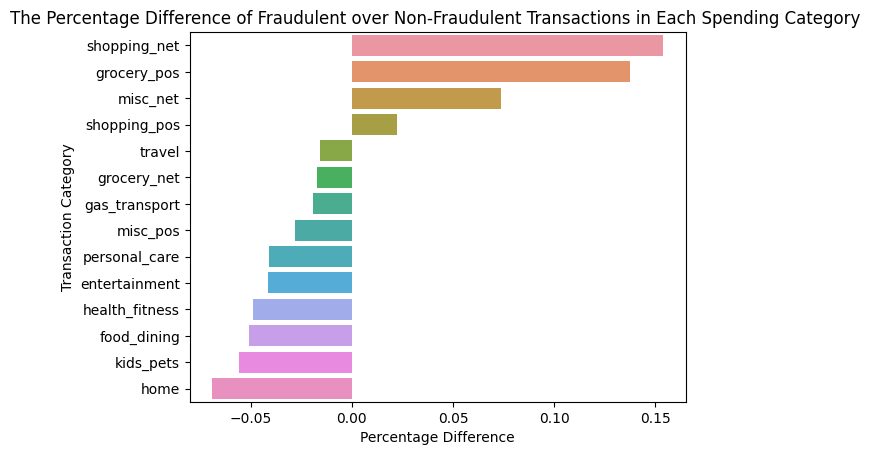

In [17]:
#calculate the percentage difference
a=train[train['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=train[train['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transactions in Each Spending Category ')

Here in the plot above we can see the percentage of fraudulent over non-fraudulent transactions in each spending category.

***We can see that the spending categories on the right are more associated with fraudulent transactions than the ones on the left***

The code for this plot was taken from here: [Link](https://www.kaggle.com/code/nathanxiang/credit-card-fraud-analysis-and-modeling)

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over Non-Fraudulent Transactions in Merchant')

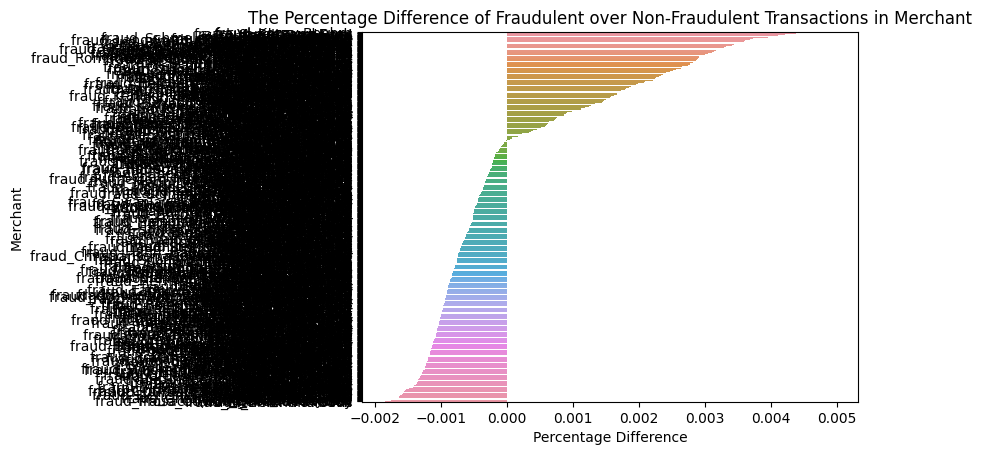

In [18]:
#calculate the percentage difference
a=train[train['is_fraud']==0]['merchant'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['merchant','not fraud percentage']

b=train[train['is_fraud']==1]['merchant'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['merchant','fraud percentage']
ab=a.merge(b,on='merchant')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='merchant',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Merchant')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transactions in Merchant')

***The plot isn't clear but we wanted to check if there is some distinct merchants that are more prone to fraud and by the low percentage number we see that aren't any.***

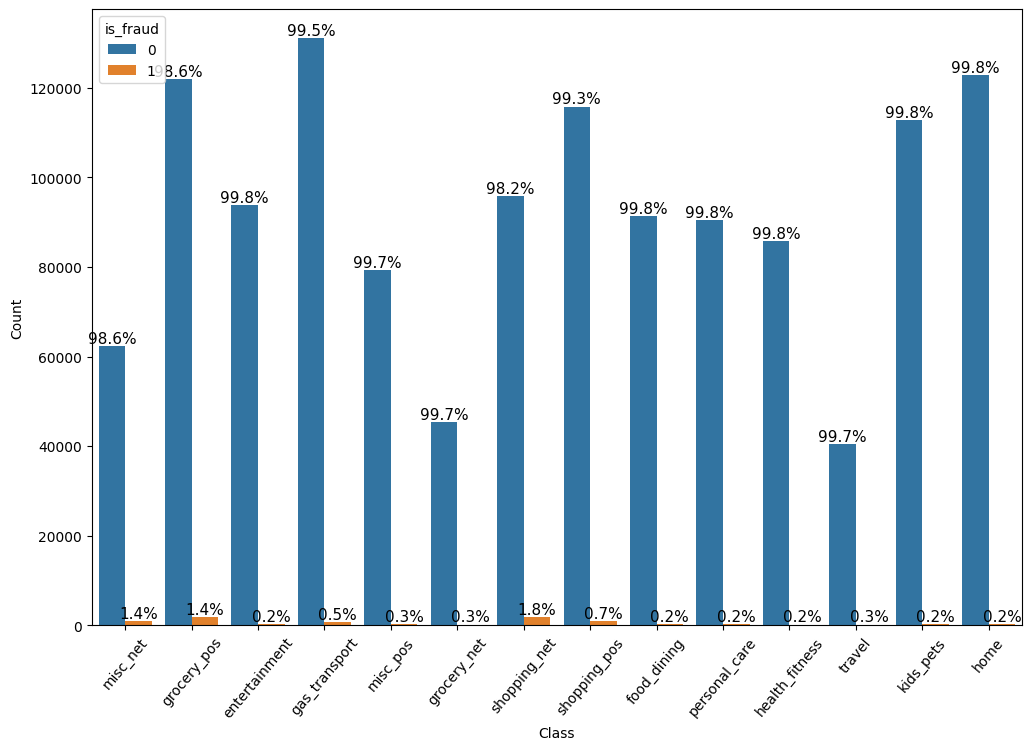

In [19]:
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')



plt.figure(figsize=(12, 8))
ax3 = sns.countplot(x="category", hue="is_fraud", data=train)
ax3.set(xlabel='Class', ylabel='Count')

percentage_above_bar_relative_to_xgroup(ax3)
plt.xticks(rotation=50)
plt.show()

Credit for the percentage plot:
[link](https://stackoverflow.com/questions/69690399/how-to-add-percentages-on-countplot-in-seaborn)

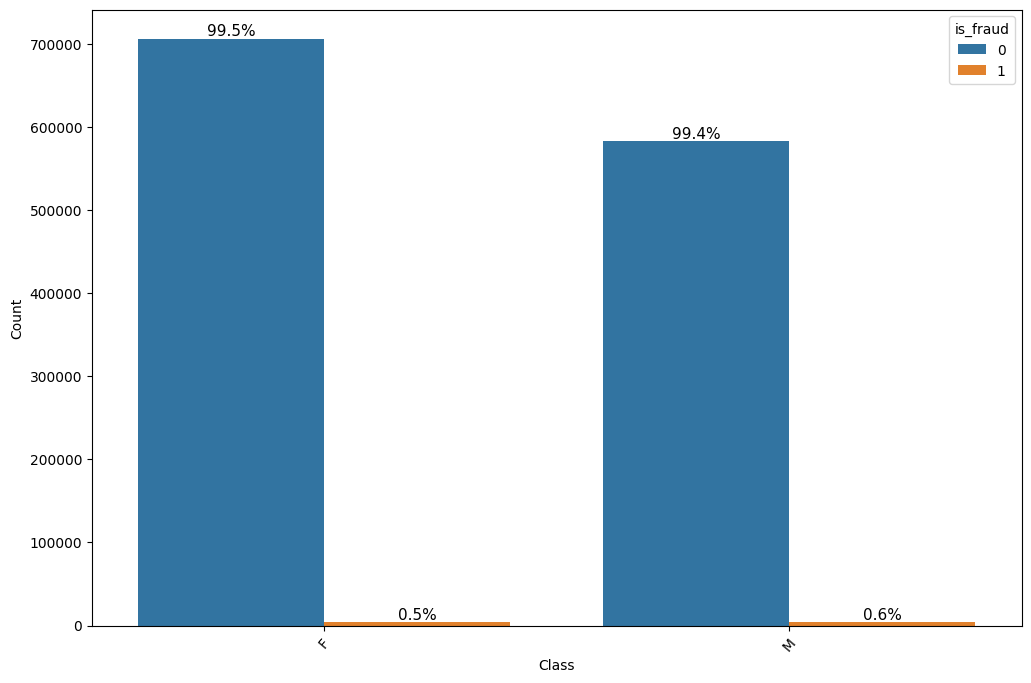

In [20]:
plt.figure(figsize=(12, 8))
ax3 = sns.countplot(x="gender", hue="is_fraud", data=train)
ax3.set(xlabel='Class', ylabel='Count')

percentage_above_bar_relative_to_xgroup(ax3)
plt.xticks(rotation=50)
plt.show()

***We can see in here that the percentage of fraudulent transaction spreads almost equally between male and female***

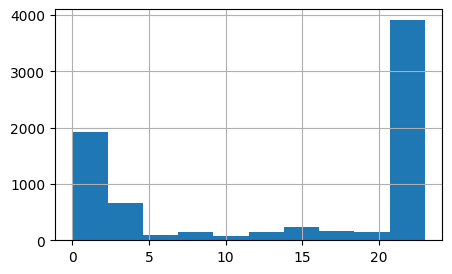

In [21]:
plt.figure(figsize=(5,3))
train[train["is_fraud"]==1].trans_hour.hist()
plt.show()

***We can see that the majority of fraudulent transactions happens in between the hours of 20:00pm - 02:00am.***

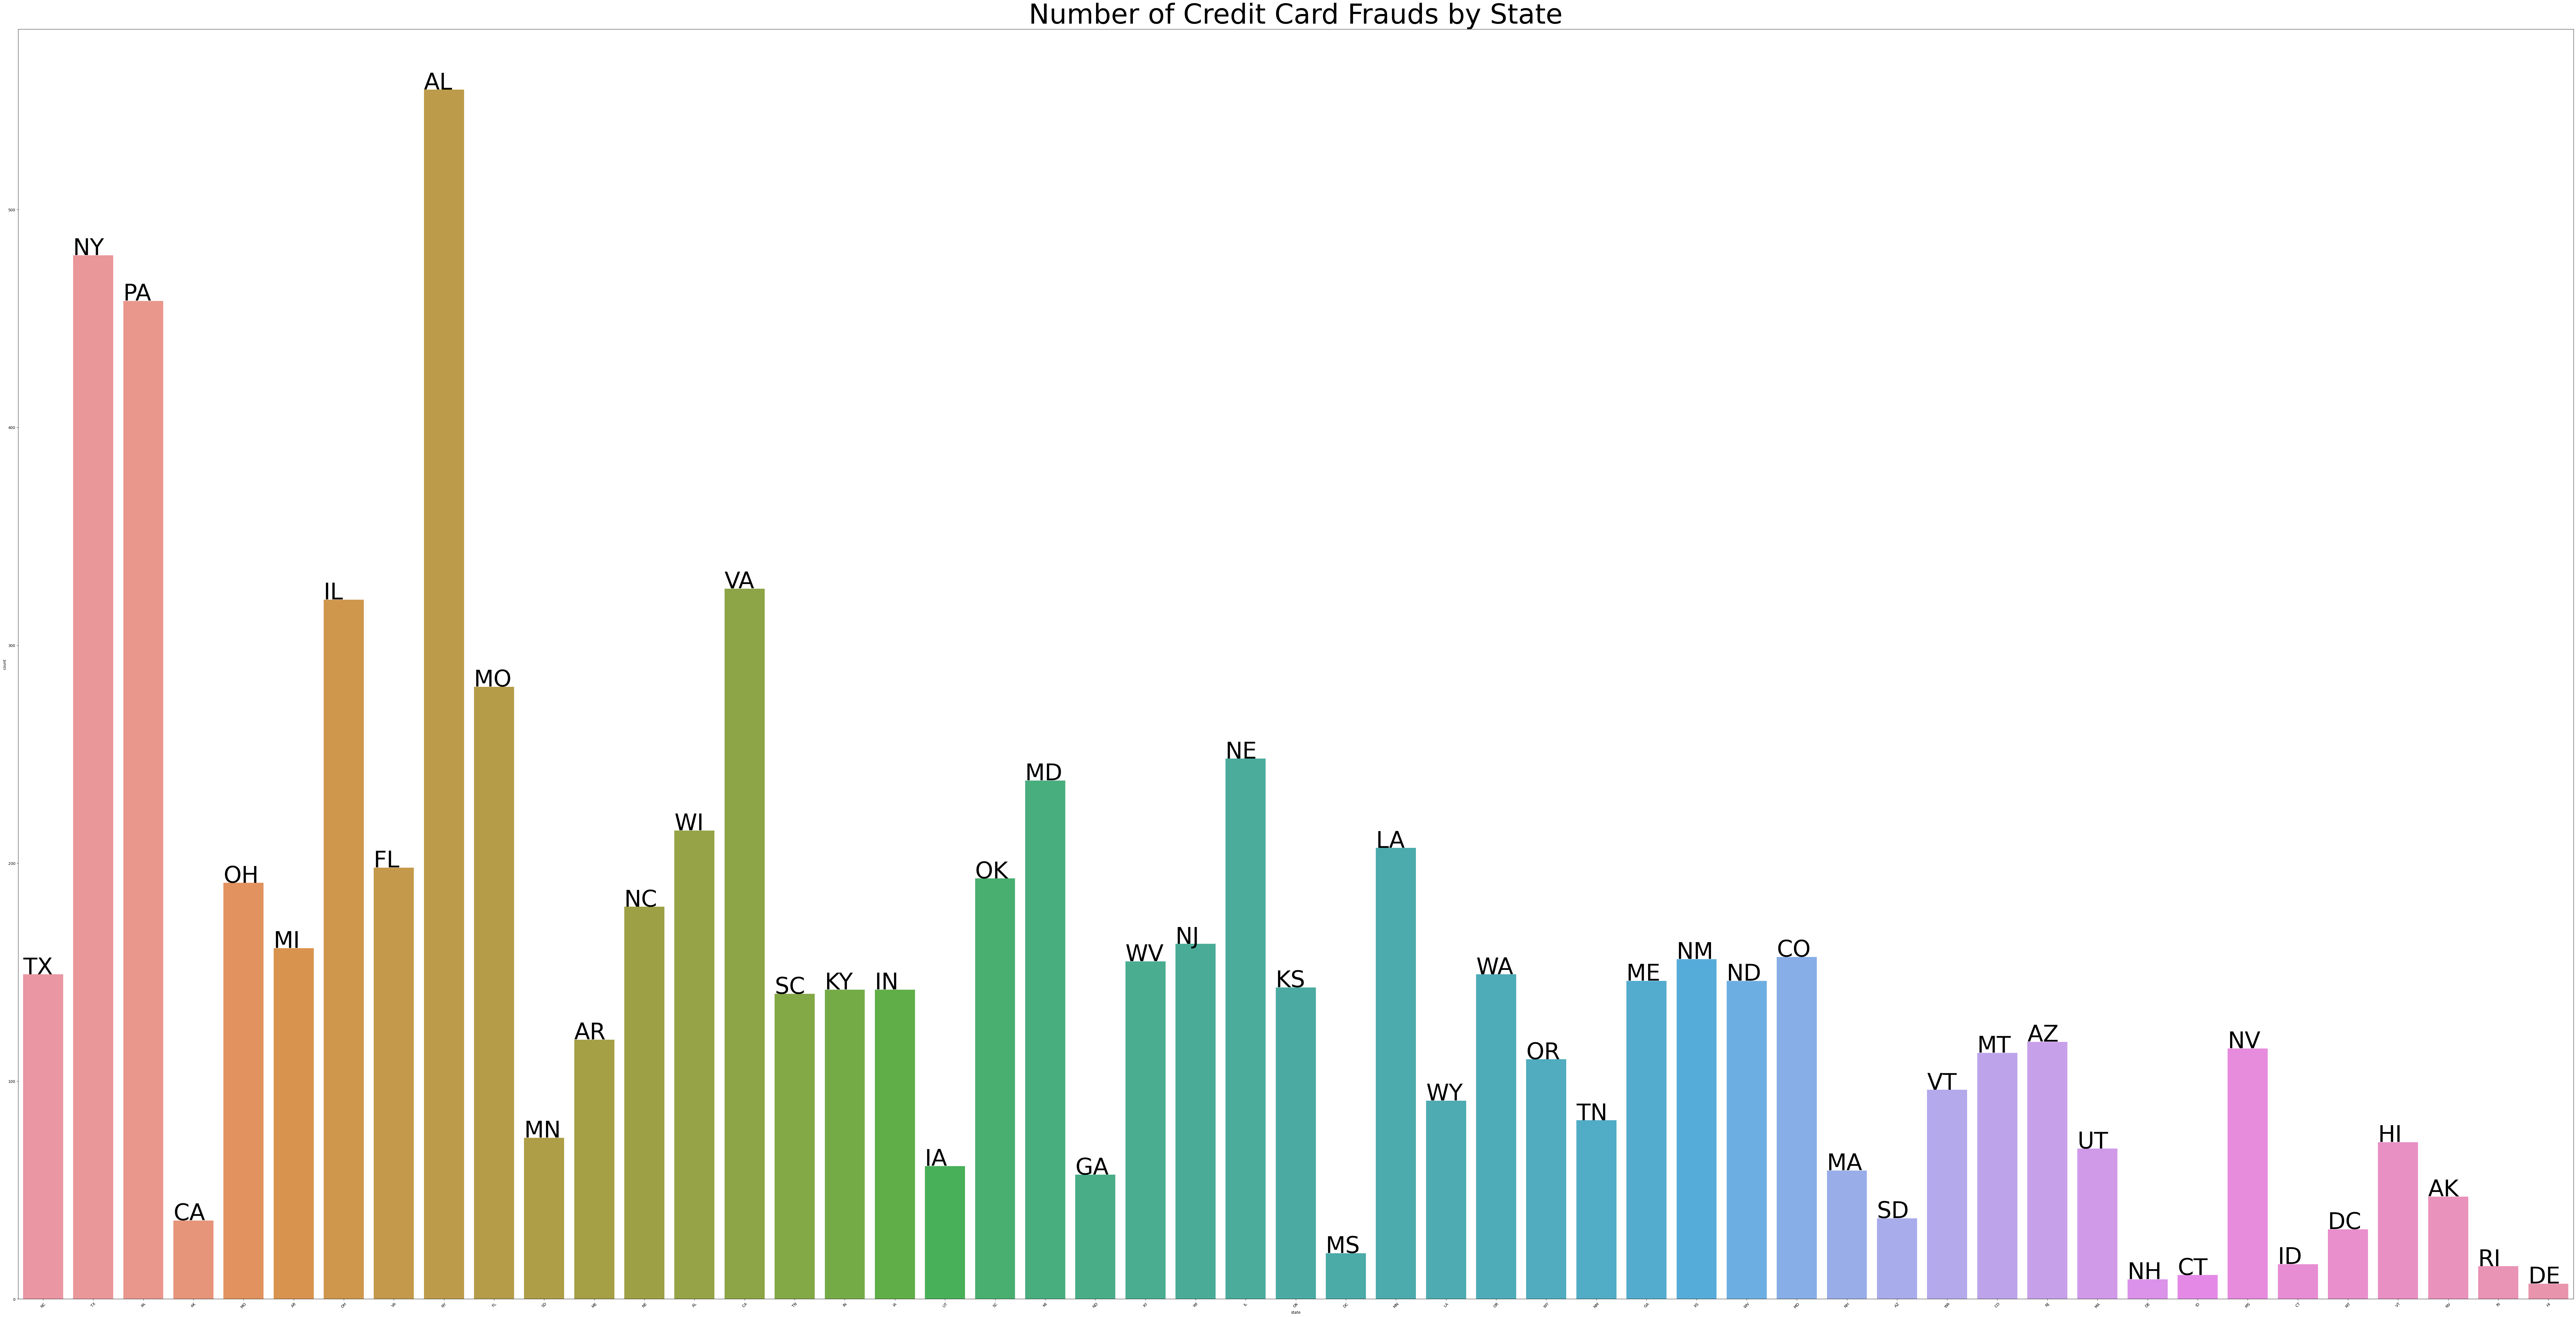

In [22]:
fig, ax = plt.subplots(figsize=(120,60))
plt.rcParams.update({'font.size': 60})
sns.countplot(x=train[train['is_fraud']==1].state)
plt.xticks(rotation=45)
for p, label in zip(ax.patches, train["state"].value_counts().index):
    ax.annotate(label, (p.get_x(), p.get_height()+0.15))
plt.title("Number of Credit Card Frauds by State")
plt.show()


***States OH, TX and LA report the most number of credit card frauds***

Please note that this graph represents the number of fraudulent cases spread over the states and it is not normalized.

credit for the graph [link](https://www.kaggle.com/code/ambarishdeb/credit-card-fraud-prediction-eda-ml-evaluation)

Text(0, 0.5, 'Individuals')

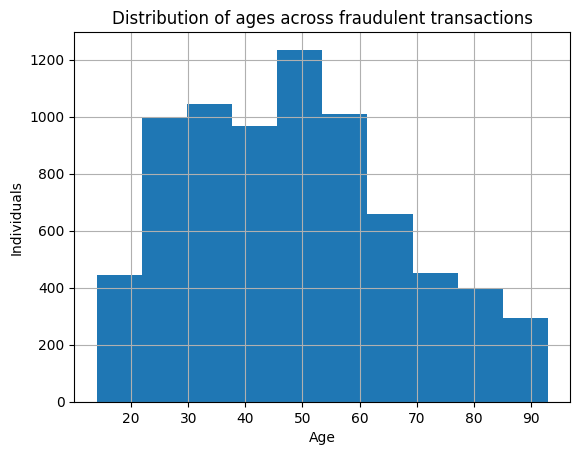

In [23]:
plt.rcParams.update({'font.size': 10})
train[train['is_fraud']==1].age.hist()
plt.title("Distribution of ages across fraudulent transactions")
plt.xlabel("Age")
plt.ylabel("Individuals")

***From the plot above we can see that we can't find any significant information***

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 29 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   category               1296675 non-null  object        
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   gender                 1296675 non-null  object        
 9   street                 1296675 non-null  object        
 10  city                   1296675 non-null  object        
 11  state                  1296675 non-null  object        
 12  zip                    12966

### The following columns are being excluded:

* unix_time - because we already have DateTime object extracted from it.

* trans_num - because it has only unique values.

* street - we think that street is too specified information.

* trans_date_trans_time - we extraced the relevant date and time (day of the month)

* cc_num - this is the identifier but it is not relevant as long as we don't look at this as a timeseries data.

* city_pop - we think that it might be irrelevant.

* dob - extracted the relevant info from there

* full_name - This was for inhouse testing

* year_ob_costumer - we extracted age from this, thus this column isn't relevant anymore 

* merchant - no distinct information was found there, moreover, there are 693 unique values and thus encoding is not an option.

* first/last - not relevant unless we do further investigation per profile.

* City - too many unique values, not enough information in them.

* job - too many unique values, will be useful if we do user profiling.

* trans_year - not informative (low variance)







In [25]:
col_to_drop = ['Unnamed: 0','unix_time','trans_num','street', 'trans_date_trans_time','city_pop','dob', 
              'year_ob_costumer','cc_num', 'merchant','first','last', 'city','job','trans_year']

train.drop(columns=col_to_drop, inplace = True)
test.drop(columns=col_to_drop, inplace = True)

# Changing the label to numerical value
train["gender"]= train["gender"].apply(lambda x: 0 if x == 'F' else 1)
test["gender"]= test["gender"].apply(lambda x: 0 if x == 'F' else 1)

In [26]:
train.head()

,category,amt,gender,state,zip,lat,long,merch_lat,merch_long,is_fraud,trans_hour,trans_weekday,is_weekend,age
0,misc_net,4.97,0,NC,28654,36.0788,-81.1781,36.011293,-82.048315,0,0,1,0,30.0
1,grocery_pos,107.23,0,WA,99160,48.8878,-118.2105,49.159047,-118.186462,0,0,1,0,40.0
2,entertainment,220.11,1,ID,83252,42.1808,-112.2620,43.150704,-112.154481,0,0,1,0,56.0
3,gas_transport,45.00,1,MT,59632,46.2306,-112.1138,47.034331,-112.561071,0,0,1,0,51.0
4,misc_pos,41.96,1,VA,24433,38.4207,-79.4629,38.674999,-78.632459,0,0,1,0,32.0


In [27]:
y_train = train['is_fraud'].copy()
X_train = train.drop(columns=['is_fraud'])
y_test = test['is_fraud'].copy()
X_test = test.drop(columns=['is_fraud'])

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1296675, 13)
y_train shape: (1296675,)
X_test shape: (555719, 13)
y_test shape: (555719,)


## Baseline Model

Creating a simple minimum viable model, doing appropriate preprocessing and cross-validating a linear model.


**Could not use SMOTE (but it should be used here) because of this error: ModuleNotFoundError: No module named 'sklearn.neighbors' that couldn't be resolved**


In [28]:
def create_clf_pipeline(classifier, X_train, y_train, X_test, y_test):
    numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]
        )


    # Making dummies
    categorical_features = X_train.select_dtypes(include=object).columns.tolist()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    # First we use the numeric_transformer in order to not accedently scale the binary values produced from OneHotEncoder
    preprocessor = ColumnTransformer(
    transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
      ]
      )


#     classifier = DecisionTreeClassifier(criterion='entropy', max_depth=10)

    steps = [("preprocessor", preprocessor),
        ("clf", classifier)]
    
    pipeline = Pipeline(steps)
    print(np.mean(cross_val_score(pipeline, X_train, y_train, cv=10)))
    
#     pipeline = Pipeline(steps)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    matrix = classification_report(y_test,y_pred,labels=[1,0])
    print('Classification report : \n',matrix)
    
    return pipeline

In [29]:
def extract_coef(pipeline):
    categorical_features = X_train.select_dtypes(include=object).columns.tolist()
    # Extracting the column names after the pipeline processing
    cat_names =  pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    num_names = pipeline.named_steps['preprocessor'].transformers_[0][2]

    feature_names = num_names.copy()

    for i in cat_names:
        feature_names.append(i)

    model_coefficients = pipeline.named_steps['clf'].feature_importances_
    coefficients_df = pd.DataFrame(data = model_coefficients, 
                                  index = feature_names, 
                                  columns = ['Coefficient_value'])
    coefficients_df.sort_values("Coefficient_value", inplace=True, ascending=False)
    
    return coefficients_df, feature_names

In [30]:
lrg_pipeline = create_clf_pipeline(LogisticRegression(max_iter=1000),X_train, y_train, X_test, y_test)

0.9938303738942214
Classification report : 
               precision    recall  f1-score   support

           1       0.10      0.01      0.02      2145
           0       1.00      1.00      1.00    553574

    accuracy                           1.00    555719
   macro avg       0.55      0.51      0.51    555719
weighted avg       0.99      1.00      0.99    555719



**Recall** is (True Positives/(True Positives + False Negatives)), which meaures how many fraud cases fly under the radar.

**Precision** is (True Positives/(True Positives + False Positives)) evaluates how good the model is at generating as fewer false alarms as possible.

***We can see here that we got really low Recall and thus the model is not good.***

In [31]:
# Extracting the column names after the pipeline processing
categorical_features = X_train.select_dtypes(include=object).columns.tolist()
cat_names =  lrg_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
num_names = lrg_pipeline.named_steps['preprocessor'].transformers_[0][2]

feature_names = num_names.copy()

for i in cat_names:
    feature_names.append(i)

model_coefficients = lrg_pipeline.named_steps['clf'].coef_[0]
lrg_coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient_value'])
lrg_coefficients_df.sort_values("Coefficient_value", inplace=True, ascending=False)

Had to have code duplication because LRG had coef instead of feature importance

In [32]:
lrg_coefficients_df.head(15)

,Coefficient_value
state_DE,4.485167
category_grocery_pos,2.617251
state_AK,2.182978
category_misc_net,2.082104
category_gas_transport,1.682108
category_shopping_net,1.509542
category_grocery_net,1.447274
state_RI,1.446171
trans_hour,0.919917
category_shopping_pos,0.534004


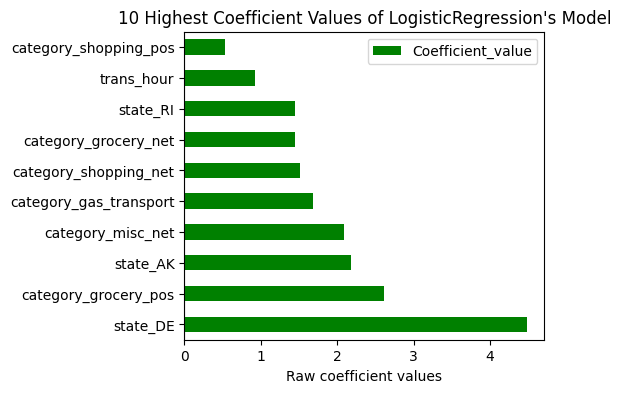

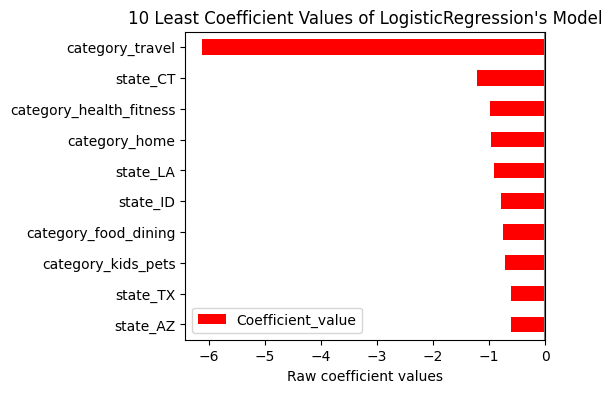

In [33]:
lrg_coefficients_df.head(10).plot.barh(figsize=(6, 4),color='g')
plt.title("10 Highest Coefficient Values of LogisticRegression's Model")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)


lrg_coefficients_df.tail(10).plot.barh(figsize=(6, 4),color='r')
plt.title("10 Least Coefficient Values of LogisticRegression's Model")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.show()

In [34]:
lrg_coefficients_df[lrg_coefficients_df.index =='trans_hour']

,Coefficient_value
trans_hour,0.919917


## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

We did in the previous section some feature engineering (extracting features from timestamp column) and removing some columns which looked unnecessary to us (explanation regarding the column removal can be found above).

Here we decided to add aditional column of **distance** which is derived from longtitude and latitude of the costumer and the merchant.

After doing the distance feature we removed the features we derived it from.
The model's results were the same with and without those features.

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   category       1296675 non-null  object 
 1   amt            1296675 non-null  float64
 2   gender         1296675 non-null  int64  
 3   state          1296675 non-null  object 
 4   zip            1296675 non-null  int64  
 5   lat            1296675 non-null  float64
 6   long           1296675 non-null  float64
 7   merch_lat      1296675 non-null  float64
 8   merch_long     1296675 non-null  float64
 9   trans_hour     1296675 non-null  int64  
 10  trans_weekday  1296675 non-null  int64  
 11  is_weekend     1296675 non-null  int64  
 12  age            1296675 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 128.6+ MB


**Creating *distance* feature, derived from longtitude and latitude of the costumer and the merchant** 

In [36]:
X_train['dist'] = X_train.apply(lambda row: h3.point_dist((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])), axis=1)
X_test['dist'] = X_test.apply(lambda row: h3.point_dist((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])), axis=1)


In [37]:
# Removing those features that were used to create the new distance feature
X_train.drop(columns=['lat','long', 'merch_lat', 'merch_long'], inplace=True)
X_test.drop(columns=['lat','long', 'merch_lat', 'merch_long'], inplace=True)

In [38]:
X_train

,category,amt,gender,state,zip,trans_hour,trans_weekday,is_weekend,age,dist
0,misc_net,4.97,0,NC,28654,0,1,0,30.0,78.597657
1,grocery_pos,107.23,0,WA,99160,0,1,0,40.0,30.212210
2,entertainment,220.11,1,ID,83252,0,1,0,56.0,108.206205
3,gas_transport,45.00,1,MT,59632,0,1,0,51.0,95.673339
4,misc_pos,41.96,1,VA,24433,0,1,0,32.0,77.556831
...,...,...,...,...,...,...,...,...,...,...
1296670,entertainment,15.56,1,UT,84735,12,6,1,58.0,119.752271
1296671,food_dining,51.70,1,MD,21790,12,6,1,40.0,75.104170
1296672,food_dining,105.93,1,NM,88325,12,6,1,52.0,99.047845
1296673,food_dining,74.90,1,SD,57756,12,6,1,39.0,84.627748


Credit for the distance calculation: [Link](https://stackoverflow.com/questions/71648993/calculate-distance-between-latitude-longitude-columns-for-pandas-data-frame)

## Main model
Using classification model to improve the result. 

In [32]:
classifiers = [
#     SVC(),
    DecisionTreeClassifier()
]

param_grid = [#{'clf__kernel': ['linear','poly']},

              {'clf__criterion' :['gini', 'entropy', 'log_loss'],
                'clf__max_depth': [2,4,6,8,10,12]}]

classifiers_names = [
    #'SVC',
    'DecisionTreeClassifier'
]


for classifier, params, name in zip(classifiers, param_grid, classifiers_names):
    print("classifier",classifier , "params", params)
    steps = [("preprocessor", preprocessor),
        ("clf", classifier)]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline, params, cv=10, return_train_score=True)
    grid.fit(X_train, y_train)
    
    exec('results_{} = pd.DataFrame(grid.cv_results_)'.format(name))
    exec('print("results_{}")'.format(name))
    
    print("Grids best estimators: ", grid.best_estimator_.steps[1][1])
    


classifier DecisionTreeClassifier() params {'clf__criterion': ['gini', 'entropy', 'log_loss'], 'clf__max_depth': [2, 4, 6, 8, 10, 12]}


/Users/desislavamarvakov/Documents/Work/Dev/Metechi/metechi-ai/work_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/desislavamarvakov/Documents/Work/Dev/Metechi/metechi-ai/work_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/desislavamarvakov/Documents/Work/Dev/Metechi/metechi-ai/work_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_param

results_DecisionTreeClassifier
Grids best estimators:  DecisionTreeClassifier(criterion='entropy', max_depth=10)


**Grids best estimators:  DecisionTreeClassifier(criterion='entropy', max_depth=10)**


### Decision Tree

In [39]:
dtree_pipeline = create_clf_pipeline(DecisionTreeClassifier(criterion='entropy', max_depth=10), X_train, y_train, X_test, y_test)

0.9985532226894328
Classification report : 
               precision    recall  f1-score   support

           1       0.89      0.79      0.84      2145
           0       1.00      1.00      1.00    553574

    accuracy                           1.00    555719
   macro avg       0.95      0.89      0.92    555719
weighted avg       1.00      1.00      1.00    555719



In [40]:
dtree_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'gender', 'zip',
                                                   'trans_hour',
                                                   'trans_weekday',
                                                   'is_weekend', 'age',
                                                   'dist']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'state'])])),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10))])

In [41]:
dtree_coefficients_df, feature_names = extract_coef(dtree_pipeline)
dtree_coefficients_df.head(10)

,Coefficient_value
amt,0.596368
trans_hour,0.100218
category_grocery_pos,0.080208
category_gas_transport,0.070770
age,0.064750
category_home,0.012699
gender,0.011640
category_entertainment,0.010969
category_travel,0.010473
category_misc_pos,0.010196


In [42]:
dtree_coefficients_df.tail(10)

,Coefficient_value
state_NE,0.0
state_ND,0.0
state_ID,0.0
state_MT,0.0
state_IN,0.0
state_KY,0.0
state_MN,0.0
state_MI,0.0
state_LA,0.0
state_WY,0.0


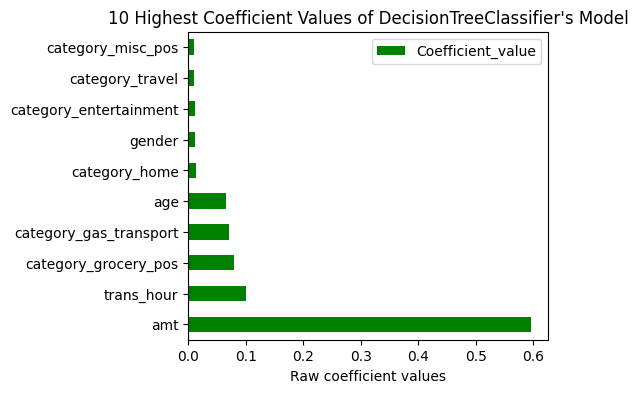

In [43]:
dtree_coefficients_df.head(10).plot.barh(figsize=(6, 4),color='g')
plt.title("10 Highest Coefficient Values of DecisionTreeClassifier's Model")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)


* **Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.** -> We tried to do the Decision Tree model without any scaling, the F1 score for the fraud label (1) was 0.

    And with the scaling, the F1 score went up to 0.83.
    
    (Could not understand why the scaling had impact on the model performance)


* **Decision trees do not need One-Hot-Encoding**, they are supposed to work better with the original categorical column (after encoding the tree will have a long trail for all the new columns and the decisions regarding them).

    We tried to do the DecisionTreeClassifier without encoding and found out the Scikit's DecisionTreeClassifier does not support non numerical input.
    
    We also tried to do Target Encoding and it gave the same good result as the normal Hot-Encoder with StandardScaler.

### SVM

In [44]:
svm_pipeline = create_clf_pipeline(SVC(max_iter=1000), X_train, y_train, X_test, y_test)

0.9003621171415779
Classification report : 
               precision    recall  f1-score   support

           1       0.04      0.60      0.08      2145
           0       1.00      0.95      0.97    553574

    accuracy                           0.94    555719
   macro avg       0.52      0.77      0.52    555719
weighted avg       0.99      0.94      0.97    555719



* We tried the SVM with both RBF (default) and poly kernel.

    **RBF** kernel gave the best result but still not good at all.
    
    The F1 score for label 1 (fraud) is only 0.02 (in poly kernel it was 0.0) and for DecisionTreeClassifier it is 0.83.


* We used scaler in here because RBF is a distance function and thus it is crucial.


* We tried to do GridSearch for SVM but jupyter's kernel shut down.



## Feature Selections
Identifying features that are important for the best model. 

**From the Decision Tree model above we can see that there are many features that got feature importances of 0.
Most of those features are the outcome of the One-Hot-Encoder.**

* Most of the states columns have zero feature importance (in Decision Tree) and thus we will exclude it 'state'.

* is_weekend - is also really low so we will remove it too.


***Removing state increased the F1 for label 1 (fraud) in 1% but removing is_weekend didn't have any effect on the F1 score. ***

In [45]:
X_train.drop(columns=['state','is_weekend'],inplace=True)
X_test.drop(columns=['state','is_weekend'],inplace=True)

In [46]:
dtree_pipeline_2 = create_clf_pipeline(DecisionTreeClassifier(criterion='entropy', max_depth=10), X_train, y_train, X_test, y_test)

0.9985385698540684
Classification report : 
               precision    recall  f1-score   support

           1       0.90      0.79      0.84      2145
           0       1.00      1.00      1.00    553574

    accuracy                           1.00    555719
   macro avg       0.95      0.89      0.92    555719
weighted avg       1.00      1.00      1.00    555719



In [47]:
dtree_coefficients_df_2, feature_names = extract_coef(dtree_pipeline_2)
dtree_coefficients_df_2.tail(10)

,Coefficient_value
category_food_dining,0.007023
category_misc_net,0.003672
zip,0.001948
category_kids_pets,0.001879
category_shopping_pos,0.001568
category_personal_care,0.001469
dist,0.001124
trans_weekday,0.000781
category_shopping_net,0.000176
category_health_fitness,0.000118


## Explainable model
Creating “explainable” model. <br>
<br>
An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a small number of leafs etc.

In [48]:
dtree_pipeline_exp = create_clf_pipeline(DecisionTreeClassifier(criterion='entropy', max_depth=5,max_leaf_nodes=10), X_train, y_train, X_test, y_test)

0.9972653132167825
Classification report : 
               precision    recall  f1-score   support

           1       0.85      0.60      0.70      2145
           0       1.00      1.00      1.00    553574

    accuracy                           1.00    555719
   macro avg       0.92      0.80      0.85    555719
weighted avg       1.00      1.00      1.00    555719



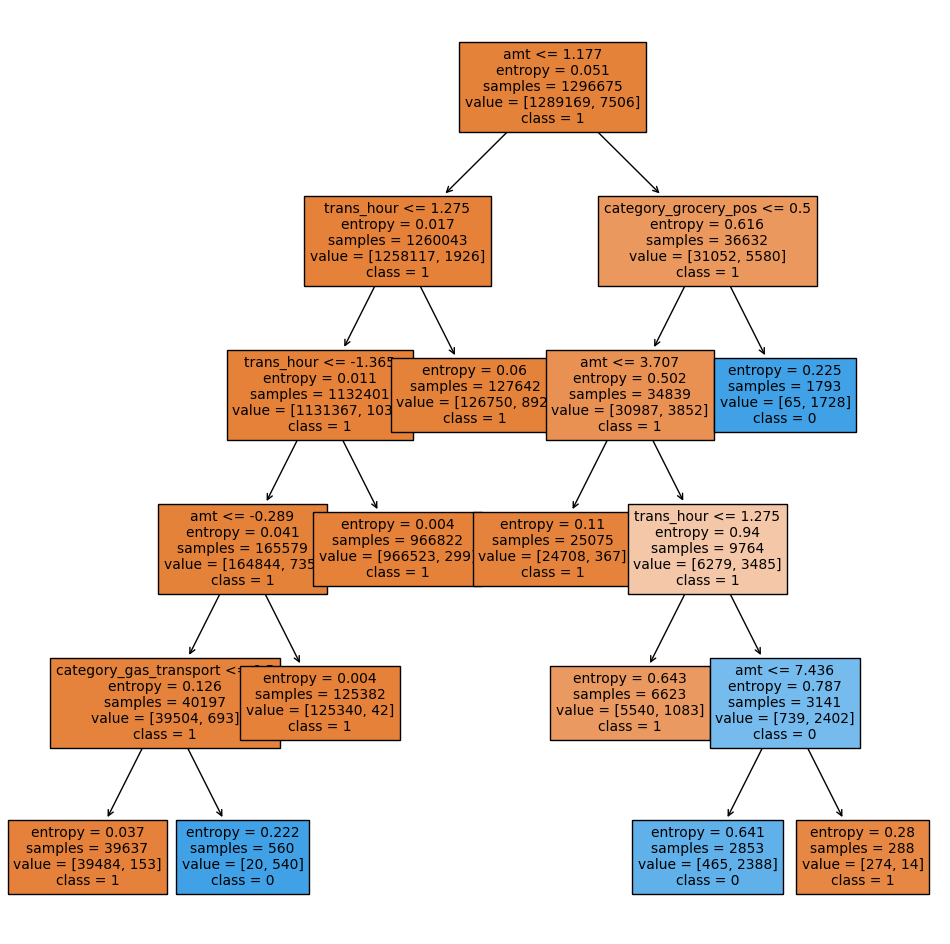

In [49]:
clf = dtree_pipeline_exp.named_steps['clf']
fn = feature_names
plt.figure(figsize=(12,12))
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=['1','0'],
               filled = True,
              fontsize=10);
fig.savefig('imagename.png')